<a href="https://colab.research.google.com/github/Dwarf789/Image-sigmentation/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Напишите PSPNet для сегментации на базе самолетов, добейтесь максимально возможной точности.


###Подгружаем библиотеки и гугл-диск

In [ ]:
from tensorflow.keras.models import Model      
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras import utils             
from google.colab import files                 
import matplotlib.pyplot as plt   
from tensorflow.keras.utils import plot_model             
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from keras.preprocessing import image
import numpy as np                             
import os                                      
from PIL import Image                          

In [ ]:
from google.colab import drive  # Подгружаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


###Загружаем датасеты

In [ ]:
a = img_to_array(load_img('/content/drive/MyDrive/Для обучения/Базы/Airplane/airplane_1.jpg'))
image_size = a.shape
image_size

(1080, 1920, 3)

In [ ]:
airplanes = [] # сюда будут заноситься полноразмерные картинки

directory = '/content/drive/MyDrive/Для обучения/Базы/Airplane' # путь
for filename in sorted(os.listdir(directory))[:10]:          # читаем из директории 
    airplanes.append(img_to_array(load_img(os.path.join(directory,filename))).astype('uint8'))

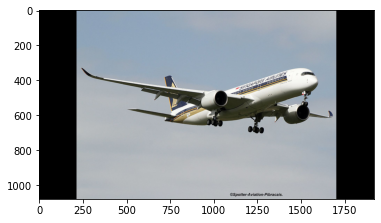

In [ ]:
# Вывод изображения
plt.imshow(airplanes[2])
plt.show()

In [ ]:
segments = [] # сюда будут заноситься карты сегментации

directory = '/content/drive/MyDrive/Для обучения/Базы/Segment' 
for filename in sorted(os.listdir(directory))[:10]:
    segments.append(img_to_array(load_img(os.path.join(directory,filename))).astype('uint8'))


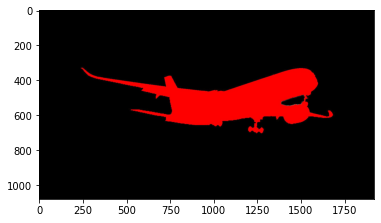

In [ ]:
# Вывод изображения
plt.imshow(segments[2])
plt.show()

In [ ]:
segments[1].shape

(1080, 1920, 3)

###Уменьшаем изображения для экономии ресурсов

In [ ]:
airplanes = []

directory = '/content/drive/MyDrive/Для обучения/Базы/Airplane'
for filename in sorted(os.listdir(directory)):
    airplanes.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(270, 480))).astype('uint8')) # для всех сетей, кроме Unet with mask используем 280.
                                                                                                                       # для Unet with mask 272

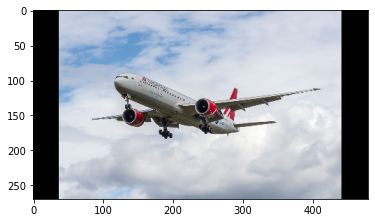

In [ ]:
# Выведем пример картинки
plt.imshow(airplanes[1])
plt.show()

In [ ]:
segments = [] # сюда будут заноситься уменьшенные карты сегментации для тренировочной выборки

directory = '/content/drive/MyDrive/Для обучения/Базы/Segment'
for filename in sorted(os.listdir(directory)):
    segments.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(270, 480))).astype('uint8'))

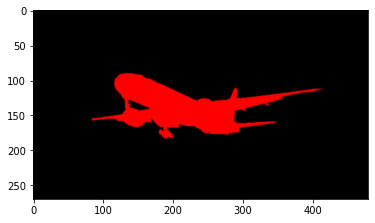

In [ ]:
# Выведем пример уменьшенной картинки yTrain
plt.imshow(segments[1])
plt.show()

In [ ]:
segments[1].shape

(270, 480, 3)

###Создаём обучающую и проверочную выборки




In [ ]:
xTrain = np.array(airplanes[:900]) # первые 900 картинок под обучающую выборку
xTest = np.array(airplanes[-100:]) # последние 100 картинок под проверочную выборку

In [ ]:
print(xTrain.shape)

(900, 270, 480, 3)


In [ ]:
yTrain = np.array(segments)

In [ ]:
print(yTrain.shape) # Выведем размерность YTrain

(1000, 270, 480, 3)


In [ ]:
yTrain[0].shape

(270, 480, 3)

In [ ]:
def ohe(dataset):
  dataset_ohe = []
  for img in range(dataset.shape[0]):
    x = dataset[img]
    lst = []
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
        if x[i][j] == 0:
          lst.append(0)
        else:
          lst.append(1)
    lst = np.array(lst)
    dataset_ohe.append(lst)
  dataset_ohe = np.array(dataset_ohe)
  dataset_ohe = dataset_ohe.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1)
  return dataset_ohe

In [ ]:
# Перекрашиваем сегментную карту в цвета по классам
yTrain = yTrain[:900]    # первые 900 картинок под обучающую выборку
ohe_yTrain = ohe(yTrain[:,:,:,0]) # переводим в one hot encoding

In [ ]:
# Перекрашиваем сегментную карту в цвета по классам
yTest = yTrain[-100:]    # первые 900 картинок под обучающую выборку
ohe_yTest = ohe(yTest[:,:,:,0]) # переводим в one hot encoding

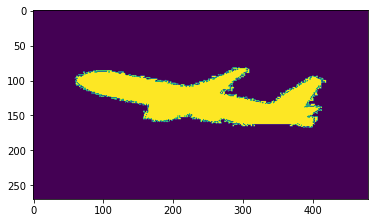

In [ ]:
# Выведем пример картинки yTrain
plt.imshow(ohe_yTrain[0][:,:,-1])

In [ ]:
ohe_yTest.shape

(100, 270, 480, 1)

### Создаём PSP-сеть

In [ ]:
input_shape = (270, 480, 3)

In [ ]:
input = Input(input_shape)

c1 = Conv2D(64, 3, padding= 'same', activation='relu')(input)
c1 = Conv2D(64, 3, padding= 'same', activation='relu')(c1)

mp1 = MaxPooling2D(pool_size=(2, 2))(c1)
mp2 = MaxPooling2D(pool_size=(6, 6))(c1)
mp3 = MaxPooling2D(pool_size=(10, 10))(c1)


c2_mp1 = BatchNormalization()(mp1)
c2_mp1 = Conv2D(64, 3, padding= 'same', activation='relu')(c2_mp1)
c2_mp1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu')(c2_mp1)

c2_mp2 = BatchNormalization()(mp2)
c2_mp2 = Conv2D(64, 3, padding= 'same', activation='relu')(c2_mp2)
c2_mp2 = Conv2DTranspose(64, (6, 6), strides=(6, 6), activation='relu')(c2_mp2)

c2_mp3 = BatchNormalization()(mp3)
c2_mp3 = Conv2D(64, 3, padding= 'same', activation='relu')(c2_mp3)
c2_mp3 = Conv2DTranspose(64, (10, 10), strides=(10, 10), activation='relu')(c2_mp3)

conc = concatenate([c2_mp1, c2_mp2, c2_mp3])

c3 = Conv2D(64, 3, padding= 'same', activation='relu')(conc)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32, 3, padding= 'same', activation='relu')(c3)

model = Model(input, c3)

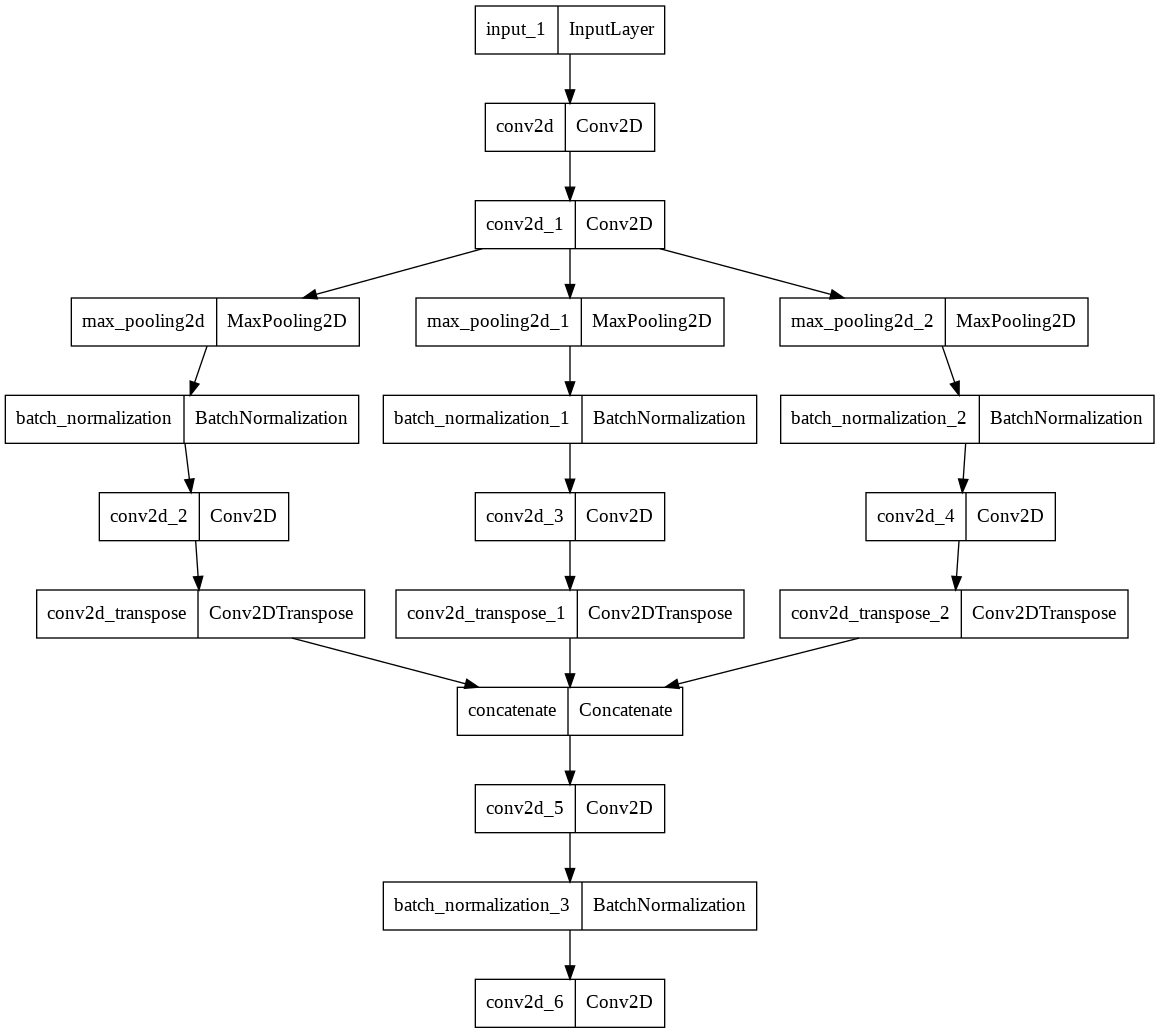

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics='accuracy')
history = model.fit(xTrain, ohe_yTrain, epochs=20, batch_size=5, validation_data = (xTest, ohe_yTest))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
180/180 [==============================] - 50s 258ms/step - loss: 0.3679 - accuracy: 0.0820 - val_loss: 0.5459 - val_accuracy: 0.0310
Epoch 2/20
180/180 [==============================] - 47s 260ms/step - loss: 0.2996 - accuracy: 0.0911 - val_loss: 0.5122 - val_accuracy: 0.1490
Epoch 3/20
180/180 [==============================] - 47s 264ms/step - loss: 0.2850 - accuracy: 0.1052 - val_loss: 0.5378 - val_accuracy: 0.0451
Epoch 4/20
180/180 [==============================] - 49s 270ms/step - loss: 0.2863 - accuracy: 0.1309 - val_loss: 0.5090 - val_accuracy: 0.1214
Epoch 5/20
180/180 [==============================] - 48s 267ms/step - loss: 0.2563 - accuracy: 0.1353 - val_loss: 0.8753 - val_accuracy: 0.1404
Epoch 6/20
180/180 [==============================] - 49s 273ms/step - loss: 0.2476 - accuracy: 0.1436 - val_loss: 0.4896 - val_accuracy: 0.0321
Epoch 7/20
180/180 [==============================] - 48s 269ms/step - loss: 0.2486 - accuracy: 0.1251 - val_loss: 0.4820 - val_ac

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics='accuracy')
history = model.fit(xTrain, ohe_yTrain, epochs=50, batch_size=5, validation_data = (xTest, ohe_yTest))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
180/180 [==============================] - 50s 271ms/step - loss: 0.1991 - accuracy: 0.1170 - val_loss: 0.4963 - val_accuracy: 0.0959
Epoch 2/50
180/180 [==============================] - 49s 271ms/step - loss: 0.2172 - accuracy: 0.1004 - val_loss: 0.5250 - val_accuracy: 0.1198
Epoch 3/50
180/180 [==============================] - 49s 271ms/step - loss: 0.2026 - accuracy: 0.1173 - val_loss: 0.4851 - val_accuracy: 0.0600
Epoch 4/50
180/180 [==============================] - 48s 267ms/step - loss: 0.2023 - accuracy: 0.1025 - val_loss: 0.5634 - val_accuracy: 0.0443
Epoch 5/50
180/180 [==============================] - 48s 268ms/step - loss: 0.1946 - accuracy: 0.0653 - val_loss: 0.7766 - val_accuracy: 0.0789
Epoch 6/50
180/180 [==============================] - 48s 268ms/step - loss: 0.1936 - accuracy: 0.0877 - val_loss: 0.6408 - val_accuracy: 0.1040
Epoch 7/50
180/180 [==============================] - 49s 272ms/step - loss: 0.1935 - accuracy: 0.1028 - val_loss: 0.6195 - val_ac

In [ ]:
model.save_weights('/content/drive/MyDrive/Для обучения/psp_model.hdf5')

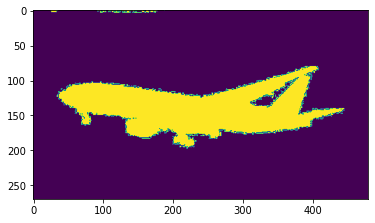

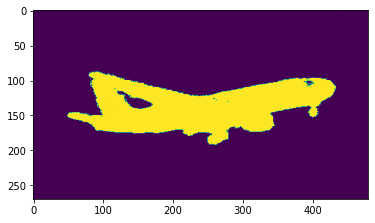

In [ ]:
model.load_weights('/content/drive/MyDrive/Для обучения/psp_model.hdf5') # Подгружаем предобученные веса
pred = model.predict(xTest[:5]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 4
plt.imshow(ohe_yTest[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()